<a href="https://colab.research.google.com/github/semueller/LecturePatternRec2_Draft/blob/main/ExercisesJupyter/exercise4/PR_sheet4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import numpy.random as rnd
import pandas as pd

import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import imageio as imageio

import scipy.spatial as spt
from scipy.sparse import diags
from scipy.spatial.distance import cdist
from scipy.integrate import odeint

# Pattern Recognition 2 - Assignment 4

---
## Exercise 1 - The Brockett double bracket flow (part 1)

In *sheet 2 task 6* you saw that the QR algorithm can sort. Some of you then asked: 
1. what is known about this phenomenon and 
2. are there are any guarantees as to the sorting capabilities of the QR algorithm?

In short the answers are: 
1. rather much and 
2. yes, there are.

While we will not go into details, we note that “one can show” that the QR algorithm is but a discretized version of a matrix gradient flow called the **Toda flow**. The Toda flow, in turn, is but a special case of a more general matrix gradient flow, namely **Brockett’s double bracket flow**
$$ \dot{H} = \Big[ H, [H, N] \Big] \tag{1}$$
where $[A, B]=AB-BA$ is the **Lie bracket**.

Depending on what we plug in for $H$ and $N$, the Brockett flow in can do many things. If you are interested in mathematical details, you may
consider these papers as starting points for self-study:
- R.W. Brockett, [“Dynamical Systems that Sort Lists and Solve Linear Programming Problems”](https://www.sciencedirect.com/science/article/pii/002437959190021N/pdf?md5=42fba9e52ca563b8d54ee742adc6ffb7&pid=1-s2.0-002437959190021N-main.pdf), Proc. IEEE Conf. on Decision and Control, 1991
- A.M. Bloch, R.W. Brockett, and T.S. Ratiu, [“Completely Integrable Gradient Flows”](https://infoscience.epfl.ch/record/129476/files/BlBrRa1992a.pdf), Comm. in Mathematical Physics, 147, 1992

In this task, we will see that the Brockett flow can compute the eigenvalues
of a symmetric matrix.

In the Data folder for this exercise, you will find the file `GaussianSample3D.csv` which contains a (zero mean) data matrix $X\in\mathbb{R}^{3\times 250}$ whose columns $x_i$ represent 3D data points. Read this matrix into memory, compute the
sample covariance matrix $C = \frac{1}{n}XX^\intercal$ and its spectral decomposition
$C = U \Lambda U^\intercal$ where you ideally use `la.eigh`. Once you are done, print the diagonal of matrix $\Lambda$.

In [2]:
matX_data = np.loadtxt('Data/GaussianSample3D.csv', delimiter=', ')
# After the loading, the 3D-data points are stored in the columns
# Lets transpose the matrix to print the first three data points
matX_data.T[:3]

array([[-1.88958002,  0.81381108,  0.1790249 ],
       [-0.56661496,  0.33216665,  0.06152226],
       [ 1.84986684,  1.53875919,  0.86953875]])

Sample covariance matrix $C = \frac{1}{n}XX^\intercal \ \in\mathbb{R}^{3\times 250}\mathbb{R}^{250\times 3} = \mathbb{R}^{3\times 3}$:

In [3]:
# matC_covariance = matX_data.T @ matX_data / matX_data.shape[0]
matC_covariance = np.cov(matX_data)
matC_covariance.shape

(3, 3)

Spectral decomposition
$C = U \Lambda U^\intercal$:

In [4]:
matU_eigen_values, matL_eigen_vectors = la.eigh(matC_covariance)
print(f"The eigenvalues according to 'la.eigh' are:\n{matU_eigen_values}")

The eigenvalues according to 'la.eigh' are:
[0.74242585 1.43294852 5.11379409]


Now, consider the following matrices as the ingredients for the Brockett double bracket flow
$$ H=C $$
$$ N=\begin{bmatrix} 1 & & \\ & 2 & \\ & & 3 \end{bmatrix} $$
and then use Scipy’s *odeint* method in order to numerically solve the first differential equation in (1).

**NOTE:** In *sheet 2 task 4*, you have already worked with `odeint`. In our current task, the difficulty is that `odeint` expects vector valued input but we are actually working with a matrix flow. Can you see, how to address this dif-
ficulty? I.e. can you see how to use `odeint` to solve matrix differential equations?

If all goes well, your use of `odeint` should produce a stack of matrices $H(0), . . . , H(T)$. Print the diagonal of matrix $H(T)$.

In [5]:
# Initialize matrix H = C
matH = matC_covariance.copy()
matH

array([[ 3.69305718, -1.46962992, -1.20016575],
       [-1.46962992,  2.36383832,  0.63643859],
       [-1.20016575,  0.63643859,  1.23227296]])

In [6]:
# Initialize matrix N using a vector of the diagonal elements
diagonal = list(range(1, 4))
matN = np.diag(diagonal)
matN

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

Recall: We need to solve
$$ \dot{H} = \Big[ H, [H, N] \Big] \tag{1}$$
where $[A, B]=AB-BA$ is the **Lie bracket**.

In [7]:
def lie_bracket(A, B):
    return A @ B - B @ A

In [8]:
def brocket_flow_derivative(H, t, N):
    H = H.reshape(N.shape)
    H = lie_bracket(H, lie_bracket(H, N))
    return H.flatten()

**Alternative:** Of course it is also possible to write the Brocket-flow as follows:

$\begin{eqnarray} &\dot{H} &=& \Big[ H, [H, N] \Big]\\
&&=& H[H,N] - [H,N]H\\
&&=& H(HN-NH) - (HN-NH)H\\
&&=& HHN-HNH - HNH-NHH\\
&&=& HHN-2 HNH-NHH\\
\end{eqnarray} $

In [9]:
# In order to pass a vector to 'odeint' we flatten the given matrix
vecH = matH.flatten()

In [10]:
# Set up the time steps for ODE solver
steps = np.linspace(0, 4, 101)
   
# Use 'odeint' to solve the Brockett flow
tenH = odeint(brocket_flow_derivative, vecH, steps, (matN,))

In [11]:
# Print a stable point (= the point the flow converges to)
matH = tenH[-1].reshape(matN.shape)
print(f"The eigenvalues according to 'odeint'/Brockett-flow are:\n{np.diag(matH)}")
print(f"The eigenvalues according to 'la.eigh' were:\n{matU_eigen_values}")
print(f"\n\nThe differences are:\n{np.diag(matH) - matU_eigen_values}")

The eigenvalues according to 'odeint'/Brockett-flow are:
[0.74366561 1.43170879 5.11379406]
The eigenvalues according to 'la.eigh' were:
[0.74242585 1.43294852 5.11379409]


The differences are:
[ 1.23975968e-03 -1.23972783e-03 -3.18509183e-08]


In [12]:
# Extract diagonals of matrices 'matH' in 'tenH' 
flow = np.array([np.diag(t.reshape(matN.shape)) for t in tenH])
flow = flow.T

##### Lets plot the evolution over time

<ipython-input-13-80143f9a3337>:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  axs = fig.add_subplot('211', facecolor='#e0e0e0')
<ipython-input-13-80143f9a3337>:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(fname, facecolor=fig.get_facecolor(), edgecolor='w',
<ipython-input-13-80143f9a3337>:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


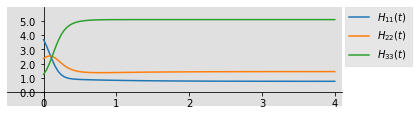

In [13]:
# Initialize figure and axes
fig = plt.figure()
fig.patch.set_facecolor('w')
axs = fig.add_subplot('211', facecolor='#e0e0e0')


# Improve the way of showing coordinate axes
for pos in ['left','bottom']:
    axs.spines[pos].set_position('zero')
    axs.spines[pos].set_zorder(1)

for pos in ['right','top']:
    axs.spines[pos].set_visible(False)
    
axs.xaxis.set_ticks_position('bottom')
axs.yaxis.set_ticks_position('left')
axs.tick_params(direction='out')

for i, lt in enumerate(flow):
    axs.plot(steps, lt, '-', label=r'$H_{%i%i}(t)$' % (i+1,i+1))

leg = axs.legend(bbox_to_anchor=(1.01,0.0,0.2,1), loc="upper left",
                    mode="expand",
                    borderaxespad=0.,
                    facecolor='#e0e0e0', edgecolor='#e0e0e0',
                    fancybox=False)

axs.set_xlim(-0.5, np.max(steps+0.1))
axs.set_ylim(-1.0, 6)
ytics = np.linspace(0, 5, 6)
#ylabs = ['${0:{1}}$'.format(t, '+' if t else '') for t in ytics]
ylabs = ['${0:{1}}$'.format(t, '') for t in ytics]
axs.set_yticks(ytics)
_ = axs.set_yticklabels(ylabs)

fname = 'BrockettEvFlow.pdf'
fmt = fname.split('.')[-1]
fig.savefig(fname, facecolor=fig.get_facecolor(), edgecolor='w',
            papertype='letter', format=fmt, transparent=False,
            pad_inches=0)  

fig.show()

---
## Exercise 2 - The Brockett double bracket flow (part 2)


If the QR algorithm is a dicretized Toda flow which is a specialized Brockett flow, then the Brocket flow should be able to sort, right? Indeed, it is!

To see an example, implement the following procedure in numpy / scipy 
1. Assume you were given a vector
$$ x = \begin{bmatrix} x_1 & x_2 & x_3 & \dots x_n \end{bmatrix}^\intercal $$
consisting of $n$ elements $x_i\in\mathbb{R}$.
1. Create an $n\times n$ tri-diagonal matrix $H$ whose main diagonal contains the elements of $x$ and whose off diagonals contain a fixed small number $\epsilon$.
$$ H= \begin{bmatrix} 
x_1 & \epsilon & & & \\
\epsilon & x_2 & \epsilon & & \\
& \epsilon & x_3 & \epsilon & \\
& & & \dots & \epsilon \\
& & & \epsilon & x_n \\
\end{bmatrix} $$
1. Create an $n\times n$ diagonal matrix $N$ whose main diagonal contains the sorted list of numbers $1, 2, \dots , n$
$$ N= \begin{bmatrix} 
1 & & & & \\ 
 & 2 & & & \\ 
 & & 3 & & \\ 
 & & & \ddots & \\
 & & & & n\\
\end{bmatrix} $$
1. use odeint to solve the Brockett flow in (1)
1. print the diagonal of matrix $H(T)$

As a specific example, run you code with the following input and parameter

$ x = \begin{bmatrix} 4 & −3 & 2 & 7 & 12 & 1 \end{bmatrix}^\intercal $

$ \epsilon = 0.01 $

In [14]:
# Task 1. - vector x to be sorted and dimension n
vecX = np.transpose([4, -3, 2, 7, 12, 1])
n = vecX.size
epsilon = 0.01
vecX

array([ 4, -3,  2,  7, 12,  1])

In [15]:
# Task 2 - matrix H
matH = np.diag(vecX) \
           + epsilon * np.diag(np.ones(n-1), +1) \
           + epsilon * np.diag(np.ones(n-1), -1)
matH

array([[ 4.0e+00,  1.0e-02,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 1.0e-02, -3.0e+00,  1.0e-02,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 0.0e+00,  1.0e-02,  2.0e+00,  1.0e-02,  0.0e+00,  0.0e+00],
       [ 0.0e+00,  0.0e+00,  1.0e-02,  7.0e+00,  1.0e-02,  0.0e+00],
       [ 0.0e+00,  0.0e+00,  0.0e+00,  1.0e-02,  1.2e+01,  1.0e-02],
       [ 0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  1.0e-02,  1.0e+00]])

In [16]:
# Task 3 - matrix N
matN = np.diag(np.arange(n)+ 1).astype(float)
matN

array([[1., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0., 0.],
       [0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 4., 0., 0.],
       [0., 0., 0., 0., 5., 0.],
       [0., 0., 0., 0., 0., 6.]])

In [17]:
# Task 4
# Initialize the matrix-representing vector
vecH = matH.flatten()
    
# Time steps for ODE solver
steps = np.linspace(0, 20, 101)
    
# Use odeint to solve the Brockett flow
tenH = odeint(brocket_flow_derivative, vecH, steps, (matN,))

In [18]:
# Task 5
# Print stable point (point the flow converges to)
matH = tenH[-1].reshape(matN.shape)
print ('Elements of sorted x:', np.round(np.diag(matH), 0).astype(int))

Elements of sorted x: [-3  1  2  4  7 12]


---
## Exercise 3 - Hopfield nets can sort


Hopfield nets are fairly versatile problem solvers. Among others, they can sort.

The following technical report discusses how the sorting problem can be cast a QUBO over binary vectors $z \in\{0, 1\}^m$
- C. Bauckhage and P. Welke [“ML2R Coding Nuggets: Sorting as a QUBO”](https://www.researchgate.net/publication/351624487_ML2R_Coding_Nuggets_Sorting_as_a_QUBO), technical report, 2021

In particular, it show the following: when dealing with an $n$-dimensional, real valued vector

$x = \begin{bmatrix} x_1 & x_2 & \dots & x_n \end{bmatrix}^\intercal $

of unsorted entries $x_l$, a QUBO formulation of the sorting problem is
$$ z^* = \underset{z\in \{0, 1\}^{n^2}}{\text{argmin}}\ z^\intercal R z - r^\intercal z \tag{2}$$

The parameters of this QUBO, i.e. matrix $R\in\mathbb{R}^{n^2\times n^2}$ and vector $r\in\mathbb{R}^{n^2}$ are computed as 
- $n = \begin{bmatrix} 1 & 2 & \dots & n \end{bmatrix}^\intercal $
- $N = \mathbb{I} \otimes n^\intercal$
- $C_r = \textbf{1}^\intercal \otimes \mathbb{I}$
- $C_c = \mathbb{I} \otimes \textbf{1}^\intercal$
- $R = \lambda_r C_r^\intercal C_r + \lambda_c C_c^\intercal C_c$
- $r = N^\intercal x + 2 (\lambda_r C_r + \lambda_c C_c)^\intercal \textbf{1}$

where $\mathbb{I}$ and $\otimes$ are the $n\times n$ identity matrix and the Kronecker product and the two scalars $\lambda_r$ and $\lambda_c$ are Lagrange multipliers which we treat as parameters that have to be set manually.

Once the problem in (2) has been solved for $z^∗$, we can turn that solution into an $n\times n$ permutation matrix $P^\intercal = \text{mat}(z^∗)$ which then allows us to compute a sorted version $y = P x$ of $x$.

**NOTE:** (2) is is written in terms of binary vectors $z$. However, for the Hopfield networks we are interested in, we require problem formulations in terms of bipolar vectors s, namely
$$ z^* = \underset{s\in \{-1, +1\}^{n^2}}{\text{argmin}}\ -\frac{1}{2} s^\intercal W s - \theta^\intercal s \tag{3}$$

### 3.1. Rewrite the problem in (2) such that is of the form in (3) (and make sure that the corresponding matrix $W$ is hollow). This is possible. You just need to be diligent with your algebraic manipulations.

To get from binary to bipolar vectors we substitute $z= \frac{1}{2}(s+1)$:

$\begin{eqnarray}
s^*&=&\underset{s\in \{\pm 1\}^n}{\text{argmin}}\ \frac{1}{4}(s+\mathbf{1})^\intercal R (s+\mathbf{1}) - \frac{1}{2}r^\intercal (s+\mathbf{1})\\
&=&\underset{s\in \{\pm 1\}^n}{\text{argmin}}\ \frac{1}{4} \big( s^\intercal + \mathbf{1}^\intercal \big) \big( Rs + R\mathbf{1} \big) - \frac{1}{2}\big( r^\intercal s + \color{grey}{q^\intercal 1}\big)\\
&=&\underset{s\in \{\pm 1\}^n}{\text{argmin}}\ \frac{1}{4} \big( s^\intercal Rs + s^\intercal R\mathbf{1} + \mathbf{1}^\intercal  Rs + \color{grey}{\mathbf{1}^\intercal R\mathbf{1}} \big) + \frac{1}{2} r^\intercal s\\
&=&\underset{s\in \{\pm 1\}^n}{\text{argmin}}\ \frac{1}{4} s^\intercal Rs + \frac{1}{2}s^\intercal R\mathbf{1} - \frac{1}{2} r^\intercal s\\
&=&\underset{s\in \{\pm 1\}^n}{\text{argmin}}\ \frac{1}{4} s^\intercal Rs + s^\intercal \frac{1}{2} \big( R\mathbf{1}-r)\\
&=&\underset{s\in \{\pm 1\}^n}{\text{argmin}}\ \frac{1}{4} s^\intercal Rs - \underbrace{\frac{1}{2} \big( r- R\mathbf{1})^\intercal}_{=:q} s
\end{eqnarray}$

Due to the definition of $C_r$ and $C_c$, $R$ is not hollow. On the diagonal is the sum $\lambda_r + \lambda_c$. Thus we get a hollow formulation as follows:

$\begin{eqnarray}
\frac{1}{4} s^\intercal Rs &=& \frac{1}{4} s^\intercal \Big( \lambda_r C_r^\intercal C_r + \lambda_c C_c^\intercal C_c \Big)s &&\text{Definition of }R\\
&=& \frac{1}{4} s^\intercal \Big( \lambda_r C_r^\intercal C_r + \lambda_c C_c^\intercal C_c -(\lambda_r+\lambda_c)\mathbb{I}+(\lambda_r+\lambda_c)\mathbb{I}\Big)s &&\text{Adding zero}\\
&=& \frac{1}{4} s^\intercal \Big( \lambda_r C_r^\intercal C_r + \lambda_c C_c^\intercal C_c -(\lambda_r+\lambda_c)\mathbb{I}\Big)s \color{grey}{\ +\frac{1}{4}s^\intercal(\lambda_r+\lambda_c)\mathbb{I} s}\\
&=& \frac{1}{4} s^\intercal \Big( \lambda_r \big(C_r^\intercal C_r-\mathbb{I}\big) + \lambda_c \big(C_c^\intercal C_c -\mathbb{I}\big)\Big)s \color{grey}{\ +\frac{1}{4}s^\intercal(\lambda_r+\lambda_c)\mathbb{I} s}\\
\end{eqnarray}$

Note that this implies, that we can simply take $R$ for the initialization of the weight matrix, and then simply set the diagonal elements of the weight matrix to zero.

Thus we obtain the desired form
$$ z^* = \underset{s\in \{-1, +1\}^{n^2}}{\text{argmin}}\ \frac{1}{2} s^\intercal W s - \theta^\intercal s \tag{3}$$

by setting:
- $W := -2 Q  \quad\in\mathbb{R}^{n^2\times n^2}$
- $q := \frac{1}{2} \big( r- R\mathbf{1})^\intercal  \quad\in\mathbb{R}^{n^2}$

where:
- $Q := \frac{1}{4}\Big( R -(\lambda_r+\lambda_c)\mathbb{I}\Big) \quad\in\mathbb{R}^{n^2\times n^2}$
- $C_r = \textbf{1}^\intercal \otimes \mathbb{I} \quad \in\mathbb{R}^{n^2}$
- $C_c = \mathbb{I} \otimes \textbf{1}^\intercal \quad \in\mathbb{R}^{n^2}$
- $R = \lambda_r C_r^\intercal C_r + \lambda_c C_c^\intercal C_c \quad\in\mathbb{R}^{n^2\times n^2}$
- $r = N^\intercal x + 2 (\lambda_r C_r + \lambda_c C_c)^\intercal \textbf{1} \quad \in\mathbb{R}^{n^2}$
- $N = \mathbb{I} \otimes n^\intercal \quad \in\mathbb{R}^{n^2}$
- $n = \begin{bmatrix} 1 & 2 & \dots & n \end{bmatrix}^\intercal \quad \in\mathbb{R}^{n}$

###### Helper functions

In [19]:
def signum(x):
    return np.where(x >= 0, +1, -1)

In [20]:
def hnet_energy(vecS, matW, vecT):
    return -0.5 * vecS @ matW @ vecS + vecT @ vecS

In [21]:
def hnet_print_time_state_energy(vecS, matW, vecT, t):
    s = ''.join(['+' if x >= 0 else '-' for x in vecS])
    E = hnet_energy(vecS, matW, vecT)
    print ('{:4d}  {}  {:+.1f}'.format(t, s, E))

###### Parameter Initialization

In [22]:
def hnet_init_sort_parameters(vecX, lambda_r=None, lambda_c=None):
    n = len(vecX)

    vecN = np.arange(n) + 1

    matI = np.eye(n)
    vec1 = np.ones(n)

    matN  = np.kron(matI, vecN)
    matCc = np.kron(matI, vec1)
    matCr = np.kron(vec1, matI)

    if lambda_r is None or lambda_c is None:
        vecX = vecX / np.sum(vecX)
        lambda_r = lambda_c = n

    matR = lambda_r * matCr.T @ matCr + lambda_c * matCc.T @ matCc
    vecR = vecX @ matN + 2 * vec1 @ (lambda_r * matCr + lambda_c * matCc)

    matQ = 0.25 * matR
    vecQ = 0.50 * (matR @ np.ones(n**2) - vecR)
    
    # Set the diagonal entries to zero to get a hollow weight matrix
    matW = -2 * matQ; np.fill_diagonal(matW, 0)

    vecT = vecQ

    return matW, vecT

### 3.2. Implement each of the following 4 algorithms for running a Hopfield network in numpy:
- random selection of updating neuron
- round robin selection of updating neuron
- greedy selection of updating neuron
- simulated annealing

###### Some helper functions

#### 3.2. - Random selection of updating neuron

In [23]:
def hnet_run_random(vecS, matW, vecT, tmax=100):
    """
    This function implements the Hopfield network with random update:
    For every of the 'tmax' updates, get a random index of the state
    that shall be updated.
    """
    for t, u in enumerate(rnd.randint(0, len(vecS), tmax)):
        hnet_print_time_state_energy(vecS, matW, vecT, t)

        vecS[u] = signum(matW[u] @ vecS - vecT[u])

    return vecS

#### 3.2. - Round robin selection of updating neuron

In [24]:
def hnet_run_round_robin(vecS, matW, vecT, rmax=100):
    """
    This function implements the Hopfield network with round Robin update:
    For every of the 'tmax' updates, iterate/update all states
    of the network.
    """
    t = 0
    for r in range(rmax):
        for u in range(len(vecS)):
            hnet_print_time_state_energy(vecS, matW, vecT, t)

            vecS[u] = signum(matW[u] @ vecS - vecT[u])

            t += 1
            
    return vecS

#### 3.2. - Greedy selection of updating neuron

In [25]:
def hnet_run_greedy(vecS, matW, vecT, tmax=100):
    """
    This function implements the Hopfield network with greedy update:
    For every of the 'tmax' updates, compute the gradient of the energy to determine
    the steepest descent. Then only update the state, that promises this steepest
    descent.
    """
    for t in range(tmax):
        hnet_print_time_state_energy(vecS, matW, vecT, t)

        gradient = matW @ vecS - vecT
        delta = vecS * gradient
        update_index = np.argmin(delta)
        vecS[update_index] = signum(gradient[update_index])

    return vecS

#### 3.2. - Simulated annealing

In [26]:
def hnet_simulated_annealing(vecS, matW, vecT, temperature_high=10, temperature_low=0.5,
                           steps=21, rmax=100):
    """
    This function implements the Hopfield network with simulated annealing:
    While decreasing the "temperature", iterate through all 'rmax' number of 
    updates and update every state with binomially distributed likelyhood.
    """    
    vecX = np.copy(vecS)
    t = 0
    for T in np.linspace(temperature_high, temperature_low, steps):
        for r in range(rmax):
            hnet_print_time_state_energy(vecS, matW, vecT, t)
                
            for i in range(len(vecS)):
                q = 1 / (1 + np.exp(-2/T * (matW[i] @ vecS - vecT[i])))
                z = rnd.binomial(n=1, p=q)
                vecS[i] = 2 * z - 1

                t = t+1

    return vecS 

### 3.3. Use each of the above algorithm to run a Hopfield net that sorts the entries of vector
$ x = \begin{bmatrix} 4 & −3 & 2 & 7 & 12 & 1 \end{bmatrix}^\intercal $

In each iteration $t$ of each algorithm print the iteration $t$, the current state $s_t$, and the energy $H_t$. To this end you may use the following snippet:

In [27]:
# Setup of the input
vecX = np.array([4, -3, 2, 7, 12, 1])
    
# Setup of the network initialization
matW, vecT = hnet_init_sort_parameters(vecX)

n = len(vecX)
vecS = -np.ones(n**2)

For each update mechanism, experiment with different initial states $s_0$ and different choices of their parameters ($t_{\text{max}}$, $r_{\text{max}}$, $T_h$, $T_l$, number of steps
between $T_h$ and $T_l \dots$). What do you observe?

In [28]:
# vecS = hnet_run_random(vecS, matW, vecT, tmax=100) # Gets stuck easily
# vecS = hnet_run_round_robin(vecS, matW, vecT, rmax=100) # Gets stuck easily
vecS = hnet_run_greedy(vecS, matW, vecT, tmax=10) # Sorts fast
# vecS = hnet_simulated_annealing(vecS, matW, vecT) # Gets stuck easily

matP = np.where(vecS>0, 1, 0).reshape(n,n).T
print(f"Attempt to sort the vector:\t{matP@vecX}")

   0  ------------------------------------  -313.5
   1  -----------------------------+------  -328.6
   2  ----------------------+------+------  -342.2
   3  ---+------------------+------+------  -354.8
   4  ---+----------+-------+------+------  -367.1
   5  ---+----------+-------+------+-+----  -379.2
   6  ---+--+-------+-------+------+-+----  -391.1
   7  ---+--+-------+-------+------+-+----  -391.1
   8  ---+--+-------+-------+------+-+----  -391.1
   9  ---+--+-------+-------+------+-+----  -391.1
Attempt to sort the vector:	[-3  1  2  4  7 12]


For each update mechanism, print an excerpt of the corresponding temporal evolution and paste them here (do not overdo this pasting, just show a couple of lines in each case).